<a href="https://colab.research.google.com/github/ojasnadkar96/cs273p_project/blob/master/randomForest_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest (PCA - 24 features)

Importing all the required libraries.<br>

In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

The two functions below are to save and import pickle files.<br>

In [0]:
def save_pkl(df,name):
    fullname = name+'.pkl'
    output = open(fullname, 'wb')
    pickle.dump(df, output)
    output.close()

In [0]:
def import_pkl(df,name):
    fullname = name+'.pkl'
    df = pickle.load(open(fullname, 'rb'))
    return df

In [0]:
df_train = pd.DataFrame()
df_valid = pd.DataFrame()
df_test = pd.DataFrame()
df_train_l = pd.DataFrame()
df_valid_l = pd.DataFrame()
df_test_l = pd.DataFrame()

In [0]:
df_train = import_pkl(df_train,'train_x')
df_valid = import_pkl(df_valid,'valid_x')
df_test = import_pkl(df_test,'test_x')
df_train_l = import_pkl(df_train_l,'train_x_l')
df_valid_l = import_pkl(df_valid_l,'valid_x_l')
df_test_l = import_pkl(df_test_l,'test_x_l')

In [0]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)
print(df_train_l.shape)
print(df_valid_l.shape)
print(df_test_l.shape)

(77854, 168)
(13737, 168)
(10175, 168)
(77854, 1)
(13737, 1)
(10175, 1)


Pre-processed data with a total of 168 features has been imported into dataframes.<br>
We will apply PCA on these datasets to reduce the dimensionality of this data.<br>


In [0]:
from sklearn.decomposition import PCA
dims = []
variances = []
optimum_dim = 168
threshold=0.01
for dim in range(1, 168):
    pca = PCA(n_components=dim)
    pca.fit(df_train)
    variance = np.array(pca.explained_variance_ratio_)
    variance = variance.min()
    if threshold < variance:
        optimum_dim = dim
        dims.append(dim)
        variances.append(variance)
    else:
        break

24


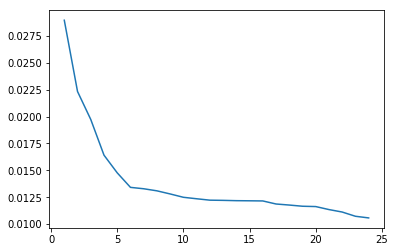

In [0]:
print(optimum_dim)
import matplotlib.pyplot as plt
plt.plot(dims, variances)
plt.show()

Optimal value for PCA is 24 features, as we can see in the graph above.

In [0]:
pca = PCA(n_components=24)
pca_train = pca.fit_transform(df_train)
print(pca.explained_variance_ratio_)

[0.0289583  0.02233305 0.0197389  0.01650096 0.01474435 0.01349737
 0.01341807 0.01308182 0.01291596 0.01258289 0.01235511 0.01218433
 0.01216399 0.01213972 0.0120766  0.01204783 0.01199531 0.01191743
 0.0118315  0.01175532 0.01170567 0.01146479 0.0107488  0.01066482]


We have now reduced the train dataset into 24 features using PCA.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(class_weight='balanced')
rf1.fit(pca_train,np.ravel(df_train_l))
score = rf1.score(pca_train,np.ravel(df_train_l))
print(score*100)

97.89863077041642


The accuracy for training data after PCA for Random Forest is around 97.8%

In [0]:
pca_valid = pca.transform(df_valid)
score = rf1.score(pca_valid,np.ravel(df_valid_l))
print(score*100)

52.23848001747107


The accuracy for validation data after PCA for Random Forest is around 52.2%<br>
This looks like overfitting, we have to look at the hyperparameters now.<br>

In [0]:
from pprint import pprint
pprint(rf1.get_params())

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


These are a parameters being used.<br>

In [0]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [10,20,30,40,50,64,128]
max_features = ['auto', 'sqrt']
max_depth = [10,20,30,40,50]
max_depth.append(None)
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 6, 10],
 'n_estimators': [10, 20, 30, 40, 50, 64, 128]}


Now, we take a set of values for each parameter and pass them through RandomizedCV for 25 iterations.<br>
This should give us a good range of better parameters.<br>

In [0]:
from sklearn.model_selection import PredefinedSplit
train_len = len(pca_train)
valid_len = len(pca_valid)
pca_tv = np.concatenate((pca_train,pca_valid), axis=0)
df_tv_l = pd.concat([df_train_l, df_valid_l], ignore_index = True)
bound = np.array([(i < train_len) * -1 for i in range(train_len + valid_len)])
split = PredefinedSplit(bound)

In the RandomizedCV model, we define a custom split for validation.<br>
Our validation data is being used as the cross-validation split for RandomizedCV.<br>
Below, we have obtained a set of hyperparameters.<br>

In [0]:
rf2 = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 25 , n_jobs = 2, verbose = 1, cv = split)
rf_random.fit(pca_tv,np.ravel(df_tv_l))
rf_random.best_params_

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  8.9min finished


{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

Using the hyperparameters obtained above, we will train our model.<br>

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(class_weight='balanced',n_estimators=50,
 min_samples_split=10,
 min_samples_leaf=4,
 max_features='sqrt',
 max_depth=20,
 bootstrap=True)
rf2.fit(pca_train,np.ravel(df_train_l))
score = rf2.score(pca_train,np.ravel(df_train_l))
print(score*100)

93.7511238985794


In [0]:
score = rf2.score(pca_valid,np.ravel(df_valid_l))
print(score*100)

51.736186940379994


The train accuracy is 93.7% and the validation accuracy is 51.7%<br>
There is less overfitting than before, but the validation accuracy is less than before.<br>
Now we will use GridSearchCV on a smaller range of values in hopes of finding good hyperparameter  values.<br>
  

In [0]:
from sklearn.model_selection import GridSearchCV

n_estimators = [50]
max_features = ['sqrt']
max_depth = [20]
max_depth.append(None)
min_samples_split = [6, 10]
min_samples_leaf = [2, 4]
bootstrap = [True]

search_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(search_grid)

{'bootstrap': [True],
 'max_depth': [20, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [6, 10],
 'n_estimators': [50]}


In [0]:
rf3 = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf3, param_grid = search_grid, n_jobs = 2, verbose = 1, cv = split)
rf_grid.fit(pca_tv, np.ravel(df_tv_l))
rf_grid.best_params_

Fitting 1 folds for each of 8 candidates, totalling 8 fits


[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:  2.8min finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50}

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf3 = RandomForestClassifier(class_weight='balanced',n_estimators=50,
 min_samples_split=10,
 min_samples_leaf=2,
 max_features='sqrt',
 max_depth=20,
 bootstrap=True)
rf3.fit(pca_train,np.ravel(df_train_l))
score_tr = rf3.score(pca_train,np.ravel(df_train_l))
print(score_tr*100)

95.11007783800447


In [0]:
score_va = rf2.score(pca_valid,np.ravel(df_valid_l))
print(score_va*100)

51.736186940379994


Again, we used GridSearchCV to get better hyperparameters.<br>
Now training accuracy is up to 95% and validation accuracy is the same at 51%<br>
The model still seems like overfitting.<br>

We will now use the parameters that were obtained in the case of Feature Set 1 (168 Features).<br>


In [0]:
from sklearn.ensemble import RandomForestClassifier
rf_final = RandomForestClassifier(class_weight='balanced',n_estimators=128,
 min_samples_split=6,
 min_samples_leaf=4,
 max_features='auto',
 max_depth=None,
 bootstrap=False)
rf_final.fit(pca_train,np.ravel(df_train_l))
score_tr = rf_final.score(pca_train,np.ravel(df_train_l))
print(score_tr*100)

99.88439900326252


In [0]:
score_va = rf_final.score(pca_valid,np.ravel(df_valid_l))
print(score_va*100)

53.148431244085316


In [0]:
pca_test = pca.transform(df_test)
score_te = rf_final.score(pca_test,np.ravel(df_test_l))
print(score_te*100)

54.692874692874696


Therefore, by using the same hyperparameters as those obtained in the 168 feature dataset we get<br>
Train accuracy as: 99.8%<br>
Validation accuracy as: 53.1%<br>
<br>
So we proceed to run the model on the test data.<br>
The test accuracy obtained is: 54.7%
<br>
This is the best test accuracy we obtained, therfore we keep these hyperparameters.<br>

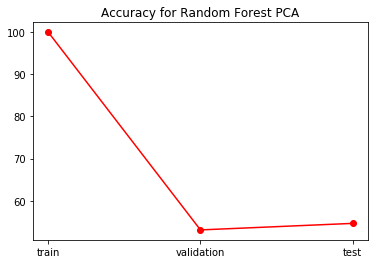

In [0]:
scores = [score_tr*100,score_va*100,score_te*100]
labels = ['train','validation','test']
plt.title("Accuracy for Random Forest PCA")
plt.plot(labels, scores, marker='o', color = "r", label = "Final model scores")
plt.show()

The graph for the best model has been plotted above.<br>
The graph shows the training, validation and test accuracy for the data.<br>